# Change in labor capacity


The fraction of the total capacity lost is given by

$$
Loss = \tfrac{1}{2}(1+ERF \left( \frac{WBGT-Prod_{mean}}{Prod_{SD} * \sqrt{2}} \right))
$$

Where WBGT is WBGTmax, WBGTmean or WBGThalf.  

| Work level | $Prod_{mean}$ | $Prod_{SD}$ |
|------------|---------------|-------------|
| 200        | 35.53         | 3.94        |
| 300        | 33.49         | 3.94        |
| 400        | 32.47         | 4.16        |



In [1]:
%matplotlib inline

from pathlib import Path


import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from numba import jit
from scipy import stats
from scipy.special import erf
# from math import erf

from tqdm import tnrange, tqdm_notebook
from config import DATA_SRC, WEATHER_SRC, POP_DATA_SRC

import population_tools

In [2]:
def labour_loss(wbgt, prod_mean, prod_sd):
    '''
    ..math:
        Loss = (1+ERF((WBGT-Prod_{mean})/(Prod_{SD} * \sqrt{2})))/2

    Args:
         WBGT is WBGTmax, WBGTmean or WBGThalf in Kelvin
         prod_mean is the mean productivity coefficient for a given power level
         prod_sd is the standard deviation coefficient for a given power level
    
    '''
    root2 = 1.4142135623730951 # np.sqrt(2)
    return (1 + erf(((wbgt - 273.15) - prod_mean) / (prod_sd * root2))) / 2



In [3]:
power_level_data = {
    200: (35.53,  3.94),
    300: (33.49, 3.94),
    400: (32.47, 4.16)
    }


MAX_YEAR = 2017
REFERENCE_YEAR_START = 1986
# NEED to finally fix whether we do 2005 or 2008!!
REFERENCE_YEAR_END = 2008

RESULTS_FOLDER = Path('./results/lancet2018/global/1.3 labour')

UN_DEMOGRAPHICS_FILE  = POP_DATA_SRC / 'UN' / 'WPP2017_PopulationByAgeSex_Medium.csv'
COUNTRY_SHAPEFILE = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

POP_FILE = POP_DATA_SRC / 'population_count_2000-2020_eightres.nc'

## Plot the labour capacity function

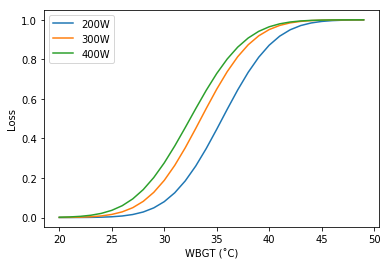

In [76]:
_wbgt = np.arange(20, 50, 1) + 273.15
labourcapacity = labour_loss(_wbgt, 35.53, 3.94)
plt.plot(_wbgt - 273.15, labourcapacity, label='200W')
labourcapacity = labour_loss(_wbgt, 33.49, 3.94)
plt.plot(_wbgt- 273.15, labourcapacity, label='300W')
labourcapacity = labour_loss(_wbgt, 32.47, 4.16)
plt.plot(_wbgt- 273.15, labourcapacity, label='400W')
plt.xlabel('WBGT (˚C)')
plt.ylabel('Loss')
plt.legend()

## Apply to WBGT mean, max, half

In [97]:
wbgt_mean = xr.open_mfdataset(
    str(WEATHER_SRC / 'ecmwf' / 'daily_wbgtmean'/ 'wbgt_mean_*.nc'),
    chunks={'time':100}
                             )
wbgt_max = xr.open_mfdataset(
    str(WEATHER_SRC / 'ecmwf' / 'daily_wbgtmax'/ 'wbgt_max_*.nc'),
    chunks={'time':100}
)

wbgt_half = xr.open_mfdataset(
    str(WEATHER_SRC / 'ecmwf' / 'daily_wbgthalf'/ 'wbgt_half_*.nc'),
    chunks={'time':100}
)

In [4]:
def hours_capacity_loss_ufunc(wbgt_mean, wbgt_max, wbgt_half, power_level):
    """
    model hourly WBGT using the 4+4+4 method giving a close approximation 
    to the hourly WBGT during the day. 4 hours per day at WBGTmax, 4 hours 
    at WBGThalf, and 4 hours at WBGTmean.
    
    2 extra conditions:  
    as people take micro-breaks during the hour we assume any work hours
    lost less than 10% is no work hours lost, and as everyone can do at 
    least 6 minutes/hour work even under extreme conditions, we assume 90% 
    work hours lost is a maximum.
    
    """
    power_level_data = {
        200: (35.53,  3.94),
        300: (33.49, 3.94),
        400: (32.47, 4.16)
        }
    
    prod_mean, prod_sd = power_level_data[float(power_level)]
    
    
    # Calculate the labour loss and clip it to the 10%/90%
    # thresholds
    loss_mean = labour_loss(wbgt_mean, prod_mean, prod_sd)
    loss_mean = xr.where(loss_mean < 0.1, 0, loss_mean)
    loss_mean = xr.where(loss_mean > 0.9, 0.9,  loss_mean)
    
    
    loss_max = labour_loss(wbgt_max, prod_mean, prod_sd)
    loss_max = xr.where(loss_max < 0.1, 0, loss_max)
    loss_max = xr.where(loss_max > 0.9, 0.9, loss_max)
    
    
    loss_half = labour_loss(wbgt_half, prod_mean, prod_sd)
    loss_half = xr.where(loss_half < 0.1, 0, loss_half)
    loss_half = xr.where(loss_half > 0.9, 0.9, loss_half)
    
    loss_hours = 4 * loss_mean + 4 * loss_max + 4 * loss_half
    return loss_hours


def save_loss_hours_for_power(power_level):
    loss_hours = xr.apply_ufunc(hours_capacity_loss_ufunc,
                     wbgt_mean.wbgt, wbgt_max.wbgt, wbgt_half.wbgt, power_level,
                     output_dtypes=[np.dtype(wbgt_mean.wbgt)],
                     dask='parallelized'
                    )

    loss_hours.name = 'loss_hours'
    loss_hours = loss_hours.resample(time='1M').sum(dim='time')
    loss_hours = loss_hours.to_dataset()
    years, datasets = zip(*loss_hours.groupby('time.year'))
    paths = [DATA_SRC / 'lancet' / f'monthly_labour_loss_hours_{power_level}'/ f'loss_hours_{y}.nc' for y in years]
    xr.save_mfdataset(datasets, paths)
        

In [113]:
power_level = 200

save_loss_hours_for_power(power_level)

In [54]:
power_level = 300

save_loss_hours_for_power(power_level)

In [114]:
power_level = 400

save_loss_hours_for_power(power_level)

# Apply the shares of worker activity

In [4]:
UN_DEMOGRAPHICS_TABLE = pd.read_csv(UN_DEMOGRAPHICS_FILE)
# Add the percentages from the population totals
UN_DEMOGRAPHICS_TABLE['PopPct'] = UN_DEMOGRAPHICS_TABLE.groupby(['LocID','Time']).PopTotal.apply(lambda g: g/g.sum())

In [5]:
# Load a country shapefile for rasterising
COUNTRIES = gpd.read_file(str(COUNTRY_SHAPEFILE))
# Translate to match raster coordinates
COUNTRIES.geometry = COUNTRIES.translate(xoff=180)

# Remove missing UN A3 code fields, convert to int and set as index
COUNTRIES.loc[COUNTRIES.un_a3 == '-099', 'un_a3'] = np.nan
COUNTRIES.un_a3 = COUNTRIES.un_a3.astype(float)
COUNTRIES = COUNTRIES[np.isfinite(COUNTRIES.un_a3)]
COUNTRIES.un_a3 = COUNTRIES.un_a3.astype(int)
COUNTRIES = COUNTRIES.set_index('un_a3')

In [6]:
agri = pd.read_excel(DATA_SRC / 'lancet' / 'PopulationERADave.xlsx', 
                     sheet_name='Country-Agemp-to-pop ratio', index_col=0)

indu = pd.read_excel(DATA_SRC / 'lancet' / 'PopulationERADave.xlsx', 
                     sheet_name='Country-Indemp-to-pop ratio', index_col=0)

serv = pd.read_excel(DATA_SRC / 'lancet' / 'PopulationERADave.xlsx', 
                     sheet_name='Country-Servemp-to-pop ratio', index_col=0)

In [7]:
# Tidy up the table and convert the date columns to numbers
agri = agri.drop('Economic activity', axis='columns')
agri.columns = agri.columns.astype(int)

indu = indu.drop('Economic activity', axis='columns')
indu.columns = indu.columns.astype(int)

serv = serv.drop('Economic activity', axis='columns')
serv.columns = serv.columns.astype(int)

In [8]:
# Add country data to sector tables
c = COUNTRIES[['iso_a3', 'iso_n3', 'geometry']]
c = c.reset_index().set_index('iso_a3')

agri = agri.join(c)
indu = indu.join(c)
serv = serv.join(c)

In [32]:
def rasterize_and_save_pct_working_age(year, pop, demographics_table, country_table, out_folder):
    
    select_rows = ((demographics_table.Variant == 'Medium')
                 & (demographics_table.Time == year)
                 & (demographics_table.AgeGrpStart >= 15))
    select_columns = ['LocID', 'PopPct']
    
    demographics = demographics_table.loc[select_rows, select_columns].groupby('LocID').PopPct.sum()
        
    countries = country_table[['geometry']].copy()
    countries['PopPct'] = demographics
    
    raster = population_tools.rasterize_data(pop.population, countries, 'PopPct')
    raster = raster * pop.water_mask.squeeze().values
    raster.shape = (*raster.shape, 1)
    raster = xr.DataArray(raster, coords=[pop.latitude, pop.longitude, [year]], 
                        dims=['latitude', 'longitude', 'year'], name='pct_working_age')

    # For some reason, Panpoly viewer doesn't like 'years' as int64 but accepts int32:/
    raster['year'] = raster['year'].astype(np.int32)

    raster.to_netcdf(str(out_folder / f'pct_working_age_{year}.nc'))

for year in tnrange(2000, MAX_YEAR+1):
    with population_tools.load_masked_population(POP_FILE) as pop_file:
        rasterize_and_save_pct_working_age(year, pop_file, 
                                       UN_DEMOGRAPHICS_TABLE, COUNTRIES, 
                                       DATA_SRC / 'lancet' / 'yearly_pct_working_age')


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

In [19]:
def rasterize_and_save_sector(sector_table, out_folder):
#     pop_file = population_tools.load_masked_population(POP_FILE)
    
    with population_tools.load_masked_population(POP_FILE) as pop_file:
        for year in tnrange(2000, MAX_YEAR+1):
            sector_table = sector_table[~pd.isna(sector_table.geometry)]
            raster = population_tools.rasterize_data(pop_file.population, sector_table, year)
            raster.shape = (*raster.shape, 1)
            raster = xr.DataArray(raster, 
                             coords=[pop_file.latitude, pop_file.longitude, [year]],
                             dims=['latitude', 'longitude', 'year'], name='pct_in_sector')
            
            # For some reason, Panpoly viewer doesn't like 'years' as int64 :/
            raster['year'] = raster['year'].astype(np.int32)
            raster = raster * pop_file.water_mask

            raster.name = 'pct_in_sector'
            raster.to_netcdf(str(out_folder / f'pct_in_sector_{year}.nc'))


In [20]:
rasterize_and_save_sector(agri, DATA_SRC / 'lancet' / 'yearly_pct_in_agri')


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

In [20]:
rasterize_and_save_sector(indu, DATA_SRC / 'lancet' / 'yearly_pct_in_indu')


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

In [21]:
rasterize_and_save_sector(serv, DATA_SRC / 'lancet' / 'yearly_pct_in_serv')


HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

# Open the generated datasets and combine

affected population for sector = population * working age fraction * fraction in sector

hours lost for sector = hours lost for power corresponding to sector * affector population for sector

hours lost total = sum of hours lost per sector across all sectors

### Assignment of sectors to work power levels

Once you have the cells proportioned between agriculture, industrial and service then you need to assign work loads to these sectors.  Clearly service sector would (on average) be about 200W and would be on average 300W with some areas (such as construction) going up to 400W, but other areas of industry (maybe clothing manufacture) being near 200W.  Agriculture is a problem, because some of this will be in the sun – which we haven’t quite got refined,  Some will be at 400W (hard work such as digging) while other work might be much less than this (berry or grape picking).  We use 400W in the shade as a ball-park average.


For a first approach, use the following simplified power assignement:


| Sector   | Power (W) |
|----------|-----------|
| Service  | 200       |
| Industry | 300       |
| Agri.    | 400       |     

In [11]:
hours_lost_200 = xr.open_mfdataset(str(DATA_SRC / 'lancet' / f'monthly_labour_loss_hours_200' / 'loss_hours_*.nc'))
hours_lost_300 = xr.open_mfdataset(str(DATA_SRC / 'lancet' / f'monthly_labour_loss_hours_300' / 'loss_hours_*.nc'))
hours_lost_400 = xr.open_mfdataset(str(DATA_SRC / 'lancet' / f'monthly_labour_loss_hours_400' / 'loss_hours_*.nc'))

In [12]:
# Calculate the yearly total hours lost for each power level
hours_lost_200 = hours_lost_200.resample(time='1Y').sum()
hours_lost_200 = hours_lost_200.rename({'time': 'year'})
hours_lost_200['year'] = hours_lost_200['year.year']

hours_lost_300 = hours_lost_300.resample(time='1Y').sum()
hours_lost_300 = hours_lost_300.rename({'time': 'year'})
hours_lost_300['year'] = hours_lost_300['year.year']

hours_lost_400 = hours_lost_400.resample(time='1Y').sum()
hours_lost_400 = hours_lost_400.rename({'time': 'year'})
hours_lost_400['year'] = hours_lost_400['year.year']

In [5]:
pct_working_age = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'yearly_pct_working_age' / 'pct_working_age_*.nc'))

In [6]:
yearly_pct_in_agri = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'yearly_pct_in_agri' / 'pct_in_sector_*.nc'))

yearly_pct_in_indu = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'yearly_pct_in_indu' / 'pct_in_sector_*.nc'))

yearly_pct_in_serv = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'yearly_pct_in_serv' / 'pct_in_sector_*.nc'))

### Map plots of loss hours

In [41]:
from cartopy import crs

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


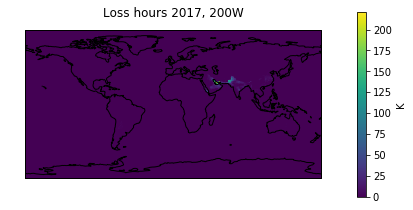

In [43]:
year = 2017
year_vals = hours_lost_200.sel(year=year).loss_hours

f = plt.figure(figsize=(6,3))

ax = plt.axes(projection=crs.PlateCarree())
year_vals.plot.pcolormesh(ax=ax,
                          transform=crs.PlateCarree(),
                          cbar_kwargs=dict(label='h'))
ax.coastlines()
ax.set_title(f'Loss hours {year}, 200W')
plt.tight_layout()

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


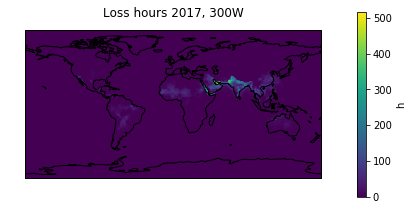

In [44]:
year = 2017
year_vals = hours_lost_300.sel(year=year).loss_hours

f = plt.figure(figsize=(6,3))

ax = plt.axes(projection=crs.PlateCarree())
year_vals.plot.pcolormesh(ax=ax,
                          transform=crs.PlateCarree(),
                          cbar_kwargs=dict(label='h'))
ax.coastlines()
ax.set_title(f'Loss hours {year}, 300W')
plt.tight_layout()

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


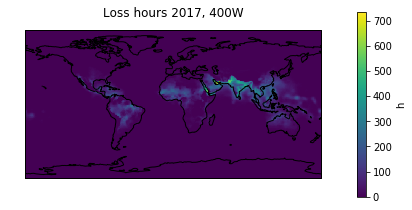

In [45]:
year = 2017
year_vals = hours_lost_400.sel(year=year).loss_hours

f = plt.figure(figsize=(6,3))

ax = plt.axes(projection=crs.PlateCarree())
year_vals.plot.pcolormesh(ax=ax,
                          transform=crs.PlateCarree(),
                          cbar_kwargs=dict(label='h'))
ax.coastlines()
ax.set_title(f'Loss hours {year}, 400W')
plt.tight_layout()

# TODO determine whether to calculate absolute loss or change relative to historical mean

### Map the loss hours for each power level onto the corresponding fraction of the population by activity


In [8]:
agri_weights = pct_working_age.pct_working_age * yearly_pct_in_agri.pct_in_sector
indu_weights = pct_working_age.pct_working_age * yearly_pct_in_indu.pct_in_sector
serv_weights = pct_working_age.pct_working_age * yearly_pct_in_serv.pct_in_sector

In [23]:
# Map population in agriculture to 400W loss hours
agri_ts = population_tools.project_to_population(hours_lost_400.loss_hours, agri_weights, end_year=MAX_YEAR)

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

In [24]:
# Map population in industry to 300W loss hours
indu_ts = population_tools.project_to_population(hours_lost_300.loss_hours, indu_weights, end_year=MAX_YEAR)

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

In [25]:
# Map population in service to 200W loss hours
serv_ts = population_tools.project_to_population(hours_lost_200.loss_hours, serv_weights, end_year=MAX_YEAR)

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

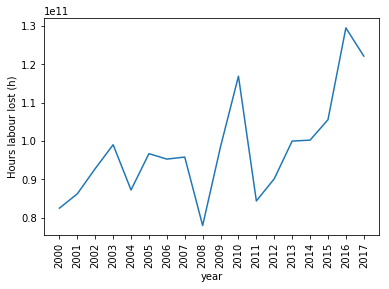

In [33]:
agri_ts.plot()
plt.ylabel('Hours labour lost (h)')
plt.xticks(agri_ts.year, rotation=90);

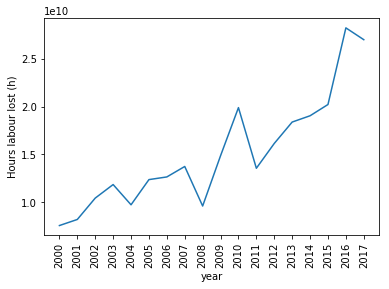

In [34]:
indu_ts.plot()
plt.ylabel('Hours labour lost (h)')
plt.xticks(indu_ts.year, rotation=90);

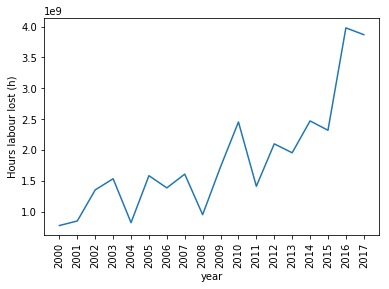

In [35]:
serv_ts.plot()
plt.ylabel('Hours labour lost (h)')
plt.xticks(agri_ts.year, rotation=90);

In [31]:
loss_hours_total = agri_ts + indu_ts + serv_ts

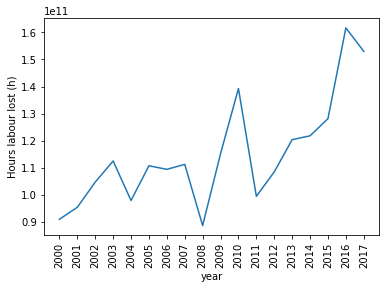

In [36]:
loss_hours_total.plot()
plt.ylabel('Hours labour lost (h)')
plt.xticks(loss_hours_total.year, rotation=90);